<a href="https://colab.research.google.com/github/danisswift/Major_Project/blob/dev/Test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev

In [90]:
!git clone https://github.com/lucasnfe/adl-piano-midi.git

fatal: destination path 'adl-piano-midi' already exists and is not an empty directory.


In [91]:
pip install --upgrade pyfluidsynth

In [92]:
pip install pretty_midi

In [93]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [94]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [95]:
!unzip /content/adl-piano-midi/midi/adl-piano-midi.zip

Streaming output truncated to the last 5000 lines.
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Disney Adventures in the Magic Kingdom/Disney_Adventures_in_the_Magic_Kingdom_TheMagicKingdom.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_Title.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_LevelOne.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_Country_Bonus_Stage.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_Country_Map.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_Country_Bonus_Lose.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country/Donkey_Kong_Country_Gang_Plank_Galleon.mid  
  inflating: adl-piano-midi/Soundtracks/Video Game Music/Donkey Kong Country 2/Donkey_Kong_Country_2_KrooksMarch.mid  
  inflatin

In [96]:
data_dir = pathlib.Path('adl-piano-midi')
filenames = glob.glob(str(data_dir/'Classical/**/**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1398


In [97]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [98]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [99]:
num_files = 75
all_notes = []
for f in filenames[:num_files]:
  try:
    notes = midi_to_notes(f)
    all_notes.append(notes)
  except Exception as e:
    print(e)
all_notes = pd.concat(all_notes)

Could not decode key with 8 sharps and mode 0


In [100]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 28306


In [101]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [102]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [103]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [104]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [105]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [106]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [107]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)


loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [108]:
losses = model.evaluate(train_ds, return_dict=True)
losses

441/441 [==============================] - 30s 56ms/step - loss: 5.2317 - duration_loss: 0.2612 - pitch_loss: 4.8439 - step_loss: 0.1267


{'duration_loss': 0.2611583173274994,
 'loss': 5.231699466705322,
 'pitch_loss': 4.843853950500488,
 'step_loss': 0.12668262422084808}

In [109]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 0.5,
        'duration':0.75,
    },
    optimizer=optimizer,
)

In [110]:
model.evaluate(train_ds, return_dict=True)

441/441 [==============================] - 26s 53ms/step - loss: 0.5014 - duration_loss: 0.2612 - pitch_loss: 4.8439 - step_loss: 0.1267


{'duration_loss': 0.2611583173274994,
 'loss': 0.5014025568962097,
 'pitch_loss': 4.843853950500488,
 'step_loss': 0.12668262422084808}

In [111]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [113]:
%%time
epochs = 40

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/40
441/441 [==============================] - 39s 89ms/step - loss: 0.2927 - duration_loss: 0.1219 - pitch_loss: 3.3539 - step_loss: 0.0672
Epoch 2/40
441/441 [==============================] - 34s 77ms/step - loss: 0.2857 - duration_loss: 0.1194 - pitch_loss: 3.2741 - step_loss: 0.0649
Epoch 3/40
441/441 [==============================] - 34s 77ms/step - loss: 0.2789 - duration_loss: 0.1175 - pitch_loss: 3.1896 - step_loss: 0.0626
Epoch 4/40
441/441 [==============================] - 35s 79ms/step - loss: 0.2722 - duration_loss: 0.1140 - pitch_loss: 3.1298 - step_loss: 0.0604
Epoch 5/40
441/441 [==============================] - 34s 77ms/step - loss: 0.2670 - duration_loss: 0.1106 - pitch_loss: 3.0923 - step_loss: 0.0588
Epoch 6/40
441/441 [==============================] - 33s 74ms/step - loss: 0.2624 - duration_loss: 0.1079 - pitch_loss: 3.0535 - step_loss: 0.0576
Epoch 7/40
441/441 [==============================] - 35s 79ms/step - loss: 0.2593 - duration_loss: 0.1056 - pit

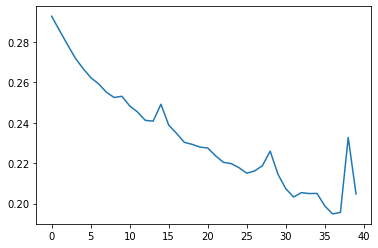

In [114]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [115]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [116]:
sample_file='tremfals.mid'
pm = pretty_midi.PrettyMIDI(sample_file)
raw_notes = midi_to_notes(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

In [123]:
temperature = 1.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [118]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [119]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [124]:
out_file = 'output14.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

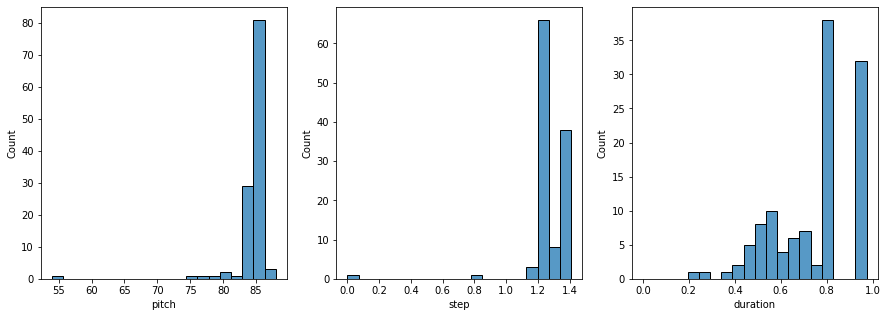

In [126]:
plot_distributions(generated_notes)

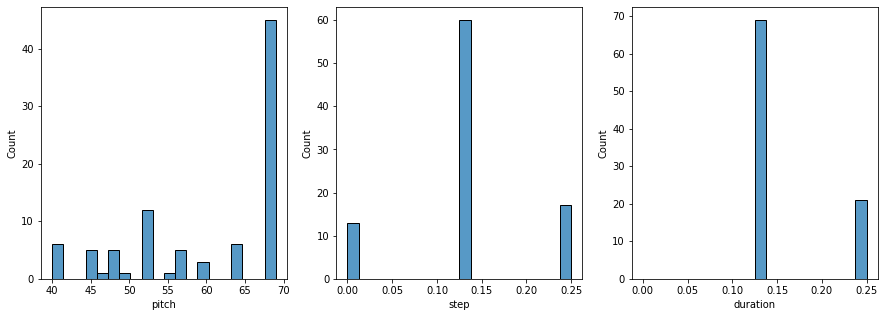

In [122]:
plot_distributions(raw_notes)